note: datahub.io has good datasets

### Imports

In [724]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### To switch datasets:

In [725]:
file = 'houses.csv'
# prediction must be within (accuracy_threshold) of the actual value to be considered correct
accuracy_threshold = 25

### Load and process the data

In [726]:
df = pd.read_csv(f'data/{file}')
print(df.shape)
to_predict = df.columns[-1]

# drop the rows with missing values
df = df.fillna(df.mean(numeric_only=True))

target = df[[to_predict]]
predictors = df.drop(to_predict, axis=1).select_dtypes(exclude=object)

(100, 5)


#### Split data into train & test sets

In [727]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, train_size=0.7, test_size=0.3)

#### Plot the data to view relationship

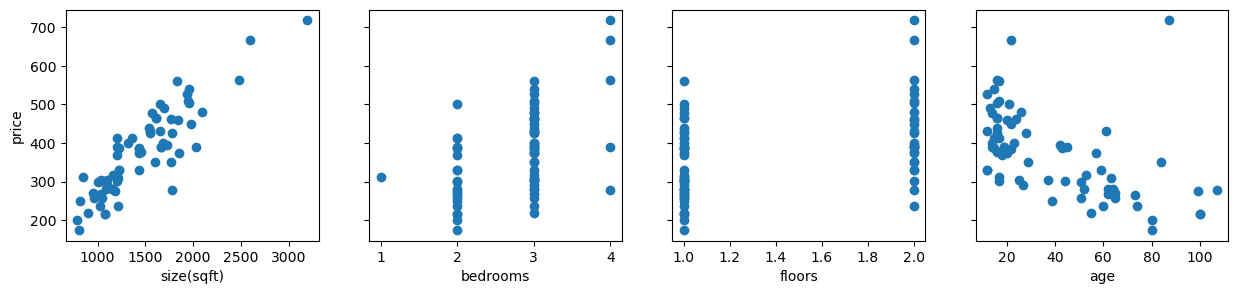

In [728]:
X_train = pd.DataFrame(X_train, columns=predictors.columns)
fig, ax = plt.subplots(1, X_train.shape[1], figsize=(15, 3), sharey=True)

if (X_train.shape[1] == 1):
  ax = [ax]

for i in range(X_train.shape[1]):
  ax[i].scatter(X_train.iloc[:,i], y_train)
  ax[i].set_xlabel(X_train.columns[i])
  
ax[0].set_ylabel(to_predict)

plt.show()

#### Scale/normalize the data

In [729]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Convert to numpy arrays

In [730]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [731]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train shape: (70, 4)
X_test.shape: (30, 4)
y_train.shape: (70, 1)
y_test.shape: (30, 1)


### Establish initial parameters

In [732]:
m, n = X_train.shape
w_init = np.zeros((n, 1))
b_init = 0.0

print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")


w_init shape: (4, 1), b_init type: <class 'float'>


### Predict function

The model's prediction with multiple variables is given by the linear model:
$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

In [733]:
def predict(X, w, b):
  '''
  Predict values using weights and inputs
  
  Args:
  X (ndarray (m,n)) : examples with multiple features
  w (ndarray (n,))  : model parameters
  b (scalar)        : model parameter

  Returns:
  p (scalar)        : prediction 
  '''

  p = np.dot(X, w) + b
  p = p.reshape(-1,1)

  return p

#### Test the predict function

In [734]:
predict(X_train, w_init, b_init).shape

(70, 1)

### Compute cost function

The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 

In [735]:
def compute_cost(X, y, w, b):
  '''
  Computes cost for a model using current parameters
  
  Args:
  X (ndarray (m,n)) : data, m examples with n features
  y (ndarray (m,))  : target values
  w (ndarray (n,))  : model parameters
  b (scalar)        : model parameter
  
  Returns:
  cost (scalar)     : cost
  '''

  m,_ = X.shape
  pred = predict(X, w, b)
  cost = ((pred - y)**2).sum()
  cost = cost / (2 * m)

  return cost

#### Test the compute cost function

In [736]:
compute_cost(X_train, y_train, w_init, b_init)

75530.08060765713

### Compute gradient function

The gradient (slope) of the cost function is given by the following equations:

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value

The gradient is computed for each feature and the bias term. The gradient is a vector with the same number of elements as the number of features. The gradient is used to update the weights and bias term.

In [737]:
def compute_gradient(X, y, w, b):
  '''
  Computes the gradient(slope of cost function)

  Args:
  X (ndarray (m,n))    : data, m examples with n features
  y (ndarray (m,))     : target values
  w (ndarray (n,))     : model parameters
  b (scalar)           : model parameter

  Returns:
  dj_dw (ndarray (n,)) : gradient of the cost w.r.t. the parameters w
  dj_db (scalar)       : gradient of the cost w.r.t. the parameter b
  '''

# non-vectorized implementation
#   m,n = X.shape           #(number of examples, number of features)
#   dj_dw = np.zeros(n,)
#   dj_db = 0.

#   for i in range(m):                             
#       err = predict(X, w, b)[i] - y[i]   
#       for j in range(n):                         
#           dj_dw[j] = dj_dw[j] + err * X[i, j]    
#       dj_db = dj_db + err                        
#   dj_dw = dj_dw / m                                
#   dj_db = dj_db / m

  # vectorized implementation
  m, _ = X.shape
  err = predict(X, w, b) - y
  dj_dw = np.dot(X.T, err) / m
  dj_db = err.sum() / m
      
  return dj_db, dj_dw

#### Test the compute gradient function

In [738]:
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')
print(f'dj_dw shape: {tmp_dj_dw.shape}')

dj_db at initial w,b: -373.1772571428572
dj_dw at initial w,b: 
 [[-95.90756493]
 [-54.4217377 ]
 [-45.63142428]
 [ 59.18848464]]
dj_dw shape: (4, 1)


### Gradient descent function

Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously, and the partial derivative terms $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ and $\frac{\partial J(\mathbf{w},b)}{\partial b}$ 

are the gradient of the cost functions for each feature, and are computed by the compute_gradient function above.

In [739]:
def gradient_descent(X, y, w, b, alpha, num_iters):
  '''
  Performs gradient descent to minimize the cost function

  Args:
  X (ndarray (m,n))    : data, m examples with n features
  y (ndarray (m,))     : target values
  w (ndarray (n,))     : model parameters
  b (scalar)           : model parameter
  alpha (scalar)       : learning rate
  num_iters (int)      : number of iterations

  Returns:
  w (ndarray (n,))     : model parameters
  b (scalar)           : model parameter
  '''

  # store the cost for each iteration
  costs = []
  for i in range(num_iters):
    dj_db, dj_dw = compute_gradient(X, y, w, b)
    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    # compute the cost
    # prevent resource exhaustion
    if i<100000:
      costs.append(compute_cost(X, y, w, b))

    # print cost 10 times
    if i % (num_iters//10) == 0:
      print(f'Cost at iteration {i}: {costs[-1]}')

  print(f'Cost at iteration {num_iters}: {costs[-1]}')

  return w, b, costs

### Run gradient descent

and display the learned parameters

In [740]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.0

# initialize hyperparameters
alpha = 3.0e-1
num_iters = 1000

# perform gradient descent
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b, alpha, num_iters)
print(f'\nw, b found by gradient descent: {w_final}, {b_final:0.2f}')

print(f'\nCost at final iteration: {J_hist[-1]}')
print(f'Cost on test set: {compute_cost(X_test, y_test, w_final, b_final)}')

Cost at iteration 0: 36355.851905033334
Cost at iteration 100: 228.33195059064158
Cost at iteration 200: 228.3310202247076
Cost at iteration 300: 228.33102022401144
Cost at iteration 400: 228.33102022401158
Cost at iteration 500: 228.33102022401158
Cost at iteration 600: 228.33102022401158
Cost at iteration 700: 228.33102022401158
Cost at iteration 800: 228.33102022401158
Cost at iteration 900: 228.33102022401158
Cost at iteration 1000: 228.33102022401158

w, b found by gradient descent: [[120.86989738]
 [-18.08955406]
 [-33.33626171]
 [-38.10779202]], 373.18

Cost at final iteration: 228.33102022401158
Cost on test set: 214.7112731265497


### Plot the model's predictions

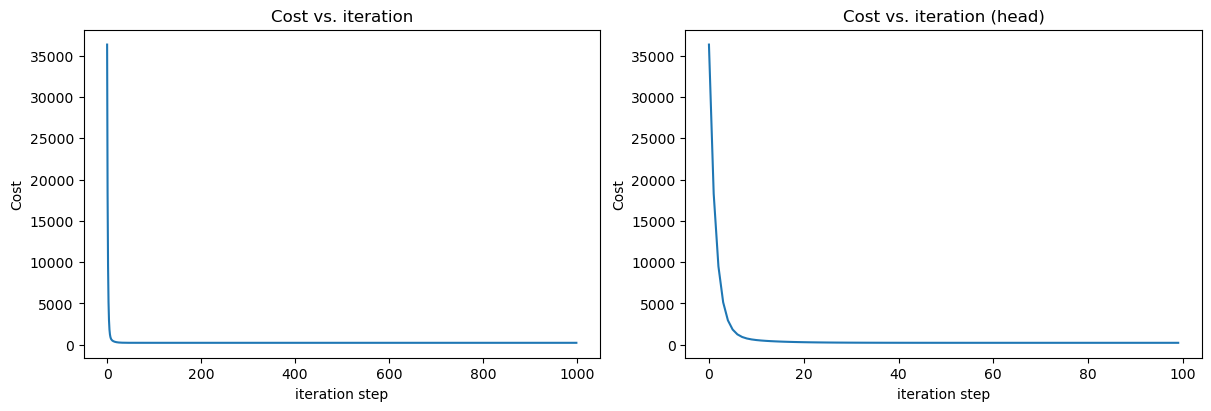

In [741]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(np.arange(len(J_hist[:100])), J_hist[:100])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (head)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

### Evaulate the model using accuracy on the test set

using the accuracy_threshold set at the top of the notebook

In [742]:
y_pred = predict(X_test, w_final, b_final)

accuracy = (abs(y_pred - y_test) < accuracy_threshold).mean()
print(f'Accuracy: %0.2f%%' % (accuracy*100)) 

Accuracy: 76.67%


### Plot the model's predictions

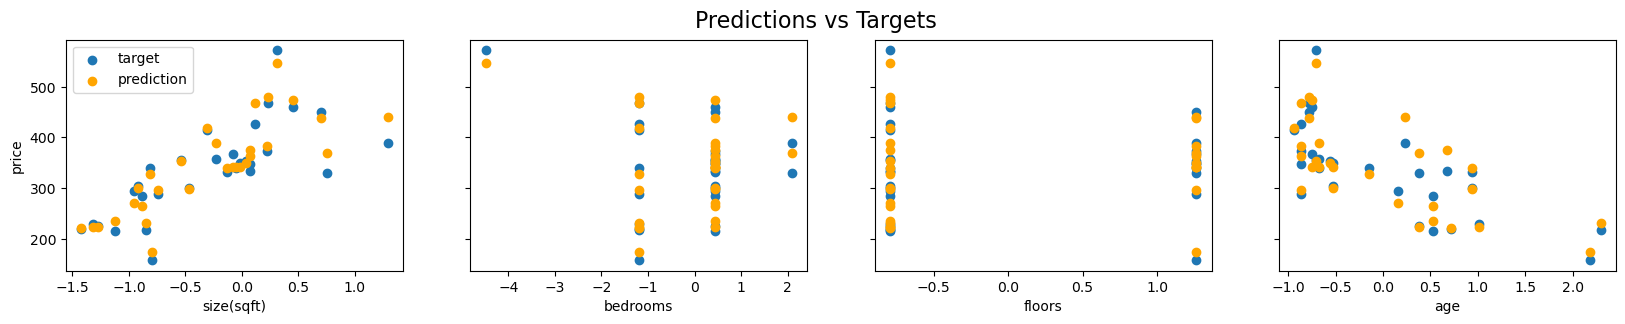

In [743]:
y_pred = predict(X_test, w_final, b_final)

fig, ax = plt.subplots(1, X_test.shape[1], figsize=(20,3), sharey=True)
if X_test.shape[1] == 1: ax = [ax]
for i in range(X_test.shape[1]):
  ax[i].scatter(X_test[:,i], y_test, label='target')
  ax[i].set_xlabel(predictors.columns[i])
  ax[i].scatter(X_test[:,i], y_pred, color = 'orange', label='prediction')
ax[0].set_ylabel(target.columns[0])
ax[0].legend()

fig.suptitle('Predictions vs Targets', fontsize=16)
plt.show()